In [12]:
import networkx as nx
import numpy as np
from walkers import Simulation
import random
random.seed(10)


In [13]:
def sample_ER(N, p):
    rd = np.random.rand(N,N)
    A = np.triu(rd < (p))
    np.fill_diagonal(A, 0)
    return A
    
def gen_com_graph(N, n_coms, p_high, p_low):
    N_pc = int(N / n_coms)
    A_struct = np.zeros((N,N))
    for i in range(n_coms):
        A_struct[i*N_pc:(i+1)*N_pc, i*N_pc:(i+1)*N_pc] = sample_ER(N_pc, p_high)
    A_random = sample_ER(N, p_low)
    A = A_struct + A_random
    

    return nx.from_numpy_matrix(A), A_struct, A_random

In [14]:
G, _, _ = gen_com_graph(30, 2, 0.3, 0.02)

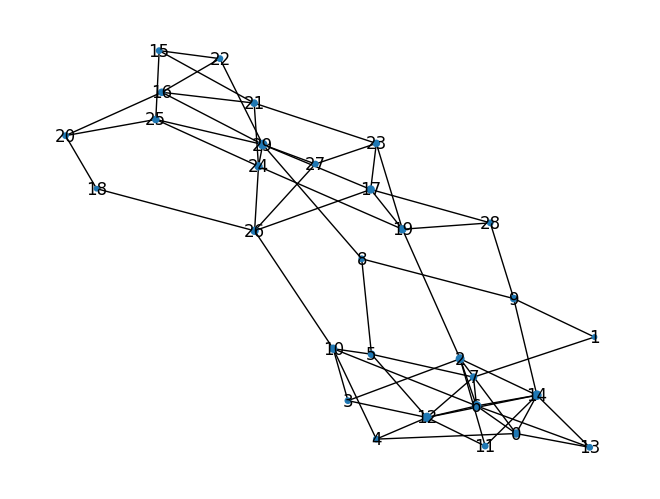

In [15]:
d = dict(G.degree)
nx.draw(G, nodelist=d.keys(), node_size=[v * 5 for v in d.values()], with_labels=True)

In [16]:
sim1 = Simulation(10000, G, 0.1, 100, 10)
sim1.run()

sim2 = Simulation(10000, G, 0.1, 100)
sim2.run()

In [17]:
print(np.shape(sim2.node_log))
print(np.shape(sim2.timeline))

(99935, 30)
(99935,)


In [37]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

[333.33333333 333.33333333 333.33333333 ... 333.33333333 333.33333333
 333.33333333]


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f306fd0ba00>,
  <matplotlib.collections.PolyCollection at 0x7f306fc68880>]}

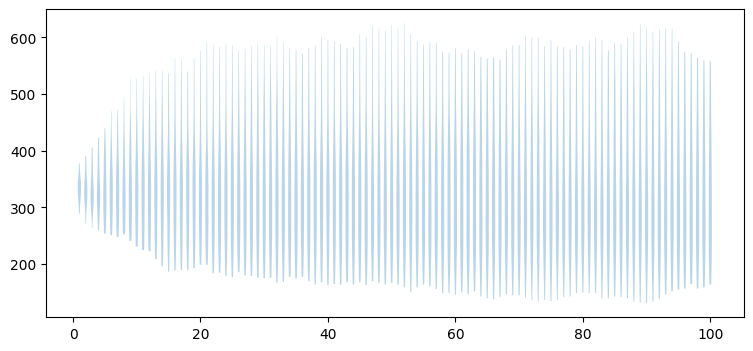

In [38]:

print(np.average(sim2.node_log, axis=1))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
ax.violinplot(
        sim2.node_log[::1000,:].T, showmeans=False, showmedians=False,
        showextrema=False)




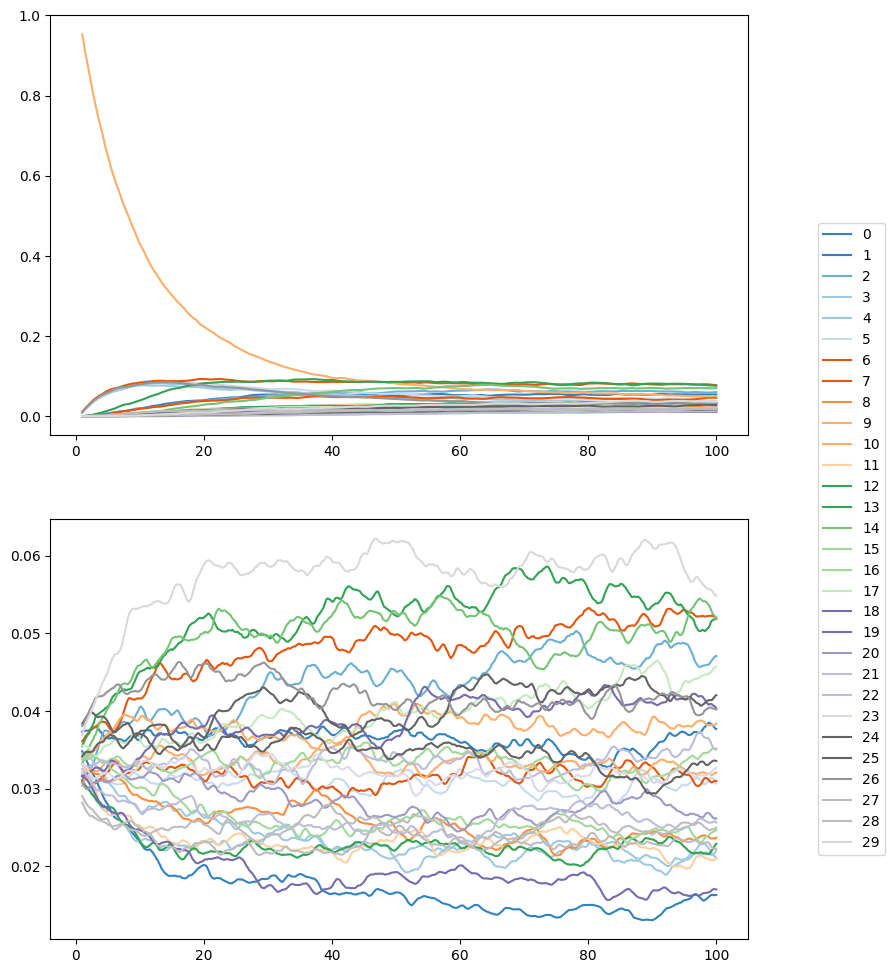

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 12))

jet = cm = plt.get_cmap('tab20c') 
cNorm  = colors.Normalize(vmin=0, vmax=sim2.G.number_of_nodes())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

for i in range(0, sim1.G.number_of_nodes(), 1):
    color_val = scalarMap.to_rgba(i)
    ma_window = 1000
    ma = moving_average(sim1.node_log[:,i], ma_window)
    ax1.plot(sim1.timeline[ma_window-1:], ma/sim1.n_walkers, label=i, color=color_val)

for i in range(0, sim2.G.number_of_nodes(), 1):
    color_val = scalarMap.to_rgba(i)
    ma_window = 1000
    ma = moving_average(sim2.node_log[:,i], ma_window)
    ax2.plot(sim2.timeline[ma_window-1:], ma/sim1.n_walkers, label=i, color=color_val)

ax1.legend(np.linspace(0, sim1.G.number_of_nodes()-1, sim1.G.number_of_nodes(), dtype=int), loc=(1.1, -1))


(array([1022.,  992., 1000.,  989.,  981., 1032.,  955.,  996., 1095.,
         938.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

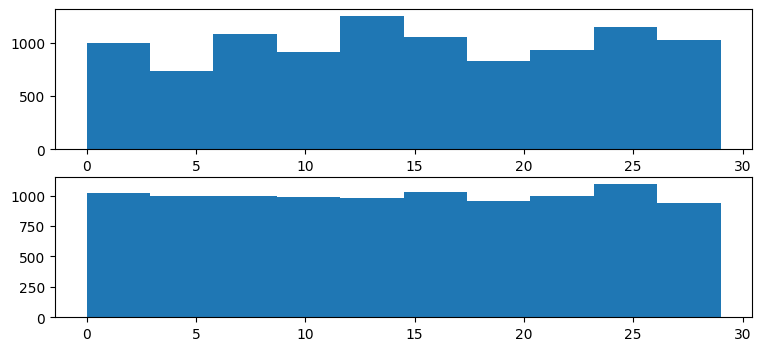

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 4))

ax1.hist(sim2.walker_log[-1,:], bins=10)


ax2.hist(sim2.walker_log[0, :], bins=10)

In [53]:
def walker_prob(lambda_, G, timeline, p_0):
    degrees = [val for (node, val) in G.degree()]
    D = np.diag(degrees)
    D_inv = np.linalg.inv(D)

    L = nx.laplacian_matrix(G).toarray()

    L_rw = np.matmul(D_inv, L)

    res = np.zeros((len(timeline), G.number_of_nodes()))

    for i in range(len(timeline)):
        t = timeline[i]
        res[i,:] = np.matmul(p_0, np.exp(-lambda_ * t * L_rw))

    return res



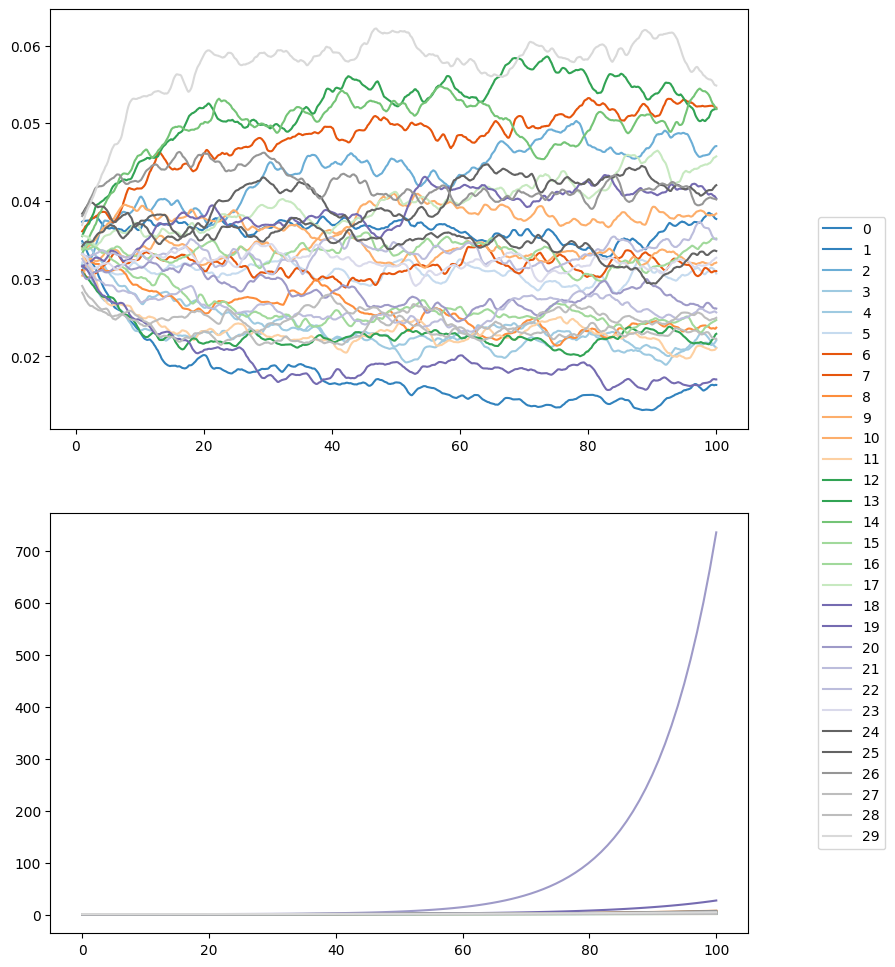

In [60]:

ig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 12))

jet = cm = plt.get_cmap('tab20c') 
cNorm  = colors.Normalize(vmin=0, vmax=sim2.G.number_of_nodes())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

for i in range(0, sim2.G.number_of_nodes(), 1):
    color_val = scalarMap.to_rgba(i)
    ma_window = 1000
    ma = moving_average(sim2.node_log[:,i], ma_window)
    ax1.plot(sim2.timeline[ma_window-1:], ma/sim2.n_walkers, label=i, color=color_val)

analytic_probs = walker_prob(
    0.1, 
    sim2.G, 
    np.linspace(0, 100, 100), 
    np.full(sim2.G.number_of_nodes(), 1/sim2.G.number_of_nodes()))
for i in range(0, sim2.G.number_of_nodes(), 1):
    color_val = scalarMap.to_rgba(i)
    ax2.plot(np.linspace(0, 100, 100), analytic_probs[:,i], label=i, color=color_val)

ax1.legend(np.linspace(0, sim1.G.number_of_nodes()-1, sim1.G.number_of_nodes(), dtype=int), loc=(1.1, -1))

